# Results to test different methods for approximating access costs at zone level

In [71]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

column_mapping = {'KNN_5': 'knn_5', 'KNN_15': 'knn_15', 'KNN_25': 'knn_25'}

outputdir = 'plots/'

In [64]:
# open a file, where you stored the pickled data
file = open('results/performance.pkl', 'rb')
# dump information to that file
performance = pickle.load(file)
# close the file
file.close()

# open a file, where you stored the pickled data
file = open('results/processing_times.pkl', 'rb')
# dump information to that file
processing_times = pickle.load(file)
# close the file
file.close()

In [65]:
res_list = []
for it in range(5):
    for stratum in ['wdam','wdpm','sat','bh']:
        iteration_results = performance[it][stratum]
        iteration_processing_times = processing_times[it][stratum]

        iteration_processing_times = iteration_processing_times.rename(columns=column_mapping)

        methods = list(iteration_results.columns[1:])


        for m in methods:
            res_append = {}
            res_append['iteration'] = it
            res_append['stratum'] = stratum
            res_append['method'] = m
            res_append['corr'] = np.corrcoef(iteration_results[m],iteration_results['GM'])[0][1]
            res_append['cost'] = iteration_processing_times[m].sum()
            res_list.append(res_append)

results = pd.DataFrame(res_list)

In [66]:
results.to_csv('results_check.csv')

Decide best parameter set for each method

- Output to excel and observe

In [67]:
methods_to_analyse = ['dbscan_0.01_3','flowhdbscan_7_5_5','hdbscan_3_3','kmean_9','knn_25','g-tgm']

methods_labels = {
    'dbscan_0.01_3':'Sp-Cl-DB',
    'flowhdbscan_7_5_5':'Flow-CL',
    'hdbscan_3_3':'Sp-Cl-HDB',
    'kmean_9':'Sp-Cl-KM',
    'knn_25':'KNN',
    'g-tgm':'G-TGM'
}

methodorder = ['Sp-Cl-KM','Sp-Cl-DB','Sp-Cl-HDB','Flow-CL','KNN','G-TGM']
methodcolors = sns.color_palette(palette='deep', n_colors=len(methodorder))

method_colour_dict = {}
c_ind = 0 
for c in methodorder:
    method_colour_dict[c] = methodcolors[c_ind]
    c_ind += 1

stratumorder = ['wdam','wdpm','sat','bh']

In [68]:
results_filt = results[results['method'].isin(methods_to_analyse)]
results_filt['method-label'] = results_filt['method'].map(methods_labels)
results_filt['corr'] = abs(results_filt['corr'])
results_filt['colour'] = results_filt['method-label'].map(method_colour_dict)
results_filt['cost hours'] = round(results_filt['cost'] / 3600, 2)

/tmp/ipykernel_155585/7078936.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_filt['method-label'] = results_filt['method'].map(methods_labels)
/tmp/ipykernel_155585/7078936.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_filt['corr'] = abs(results_filt['corr'])
/tmp/ipykernel_155585/7078936.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [69]:
grouped = results_filt.groupby(['stratum','method-label'])['corr'].mean().unstack()
grouped = grouped.reindex(methodorder, axis=1)
grouped = grouped.reindex(stratumorder, axis=0)

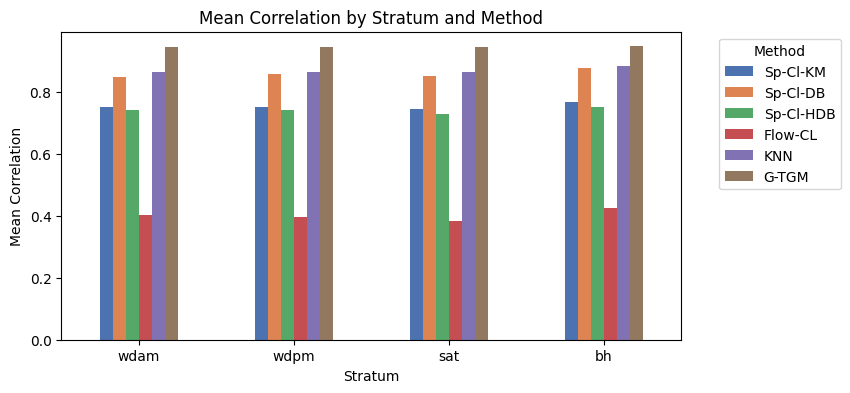

In [110]:
fig, ax = plt.subplots(1,figsize=(8,4))

grouped.plot(kind='bar', color=methodcolors, ax=ax)
ax.set_xlabel('Stratum')
ax.set_ylabel('Mean Correlation')
ax.set_title('Mean Correlation by Stratum and Method')
ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', labelrotation= 0)
plt.show()

In [9]:
groupedstd = results_filt.groupby(['stratum','method-label'])['corr'].std().unstack()
groupedstd = groupedstd.reindex(methodorder, axis=1)
groupedstd = groupedstd.reindex(stratumorder, axis=0)

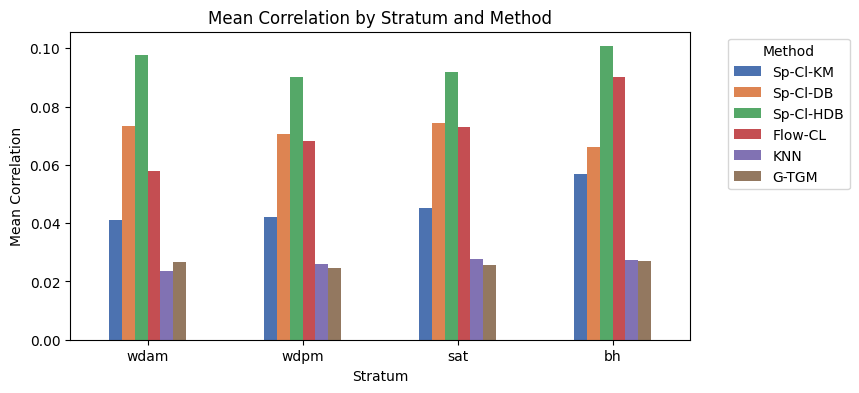

In [10]:
fig, ax = plt.subplots(1,figsize=(8,4))

groupedstd.plot(kind='bar', color=methodcolors, ax=ax)
ax.set_xlabel('Stratum')
ax.set_ylabel('Mean Correlation')
ax.set_title('Mean Correlation by Stratum and Method')
ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', labelrotation= 0)
plt.show()

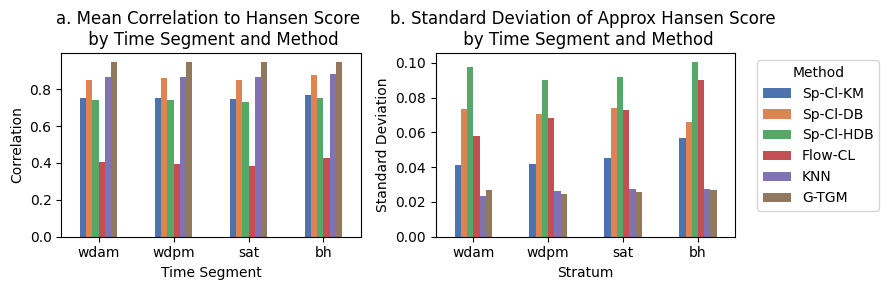

In [89]:
fig, ax = plt.subplots(1,2,figsize=(9,3))

grouped.plot(kind='bar', color=methodcolors, ax=ax[0])
ax[0].set_xlabel('Time Segment')
ax[0].set_ylabel('Correlation')
ax[0].set_title('a. Mean Correlation to Hansen Score \n by Time Segment and Method')
#ax[0].legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].get_legend().remove()
ax[0].tick_params(axis='x', labelrotation= 0)

groupedstd.plot(kind='bar', color=methodcolors, ax=ax[1])
ax[1].set_xlabel('Stratum')
ax[1].set_ylabel('Standard Deviation')
ax[1].set_title('b. Standard Deviation of Approx Hansen Score \n by Time Segment and Method')
ax[1].legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].tick_params(axis='x', labelrotation= 0)

plt.tight_layout()
plt.savefig(outputdir+'ch3_mean_std_approx_methods.pdf')
plt.show()

In [74]:
legend_handles = []
for k in method_colour_dict.keys():
    legend_handles.append(Line2D([0], [0], label=k, marker="o", markersize=8, markeredgecolor=method_colour_dict[k], markerfacecolor=method_colour_dict[k], linestyle=''))

/tmp/ipykernel_155585/3049654736.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0,0].scatter(r['cost hours'],r['corr'], c = r['colour'])
/tmp/ipykernel_155585/3049654736.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0,1].scatter(r['cost hours'],r['corr'], c = r['colour'])
/tmp/ipykernel_155585/3049654736.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoid

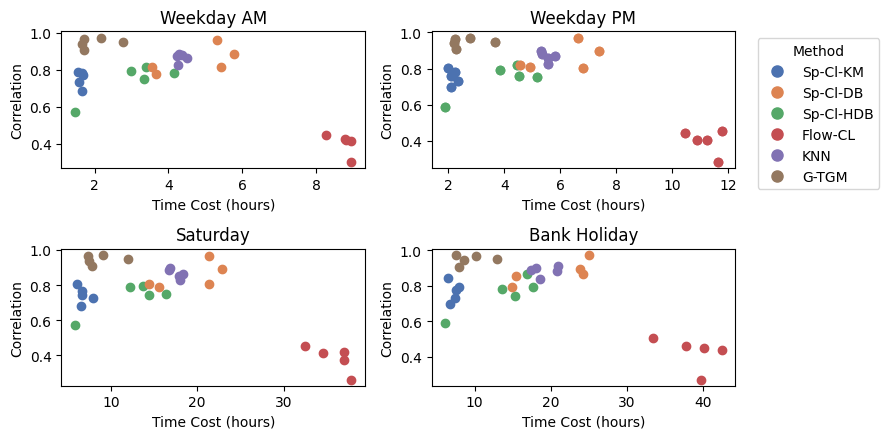

In [81]:
fig, ax = plt.subplots(2,2,figsize=(9,4.5))

for i,r in results_filt[results_filt['stratum'] == 'wdam'].iterrows():
    ax[0,0].scatter(r['cost hours'],r['corr'], c = r['colour'])
    ax[0,0].set_xlabel('Time Cost (hours)')
    ax[0,0].set_ylabel('Correlation')
    ax[0,0].set_title('Weekday AM')

for i,r in results_filt[results_filt['stratum'] == 'wdpm'].iterrows():
    ax[0,1].scatter(r['cost hours'],r['corr'], c = r['colour'])
    ax[0,1].scatter(r['cost hours'],r['corr'], c = r['colour'])
    ax[0,1].set_xlabel('Time Cost (hours)')
    ax[0,1].set_ylabel('Correlation')
    ax[0,1].set_title('Weekday PM')
    ax[0,1].legend(handles=legend_handles,title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')

for i,r in results_filt[results_filt['stratum'] == 'sat'].iterrows():
    ax[1,0].scatter(r['cost hours'],r['corr'], c = r['colour'])
    ax[1,0].set_xlabel('Time Cost (hours)')
    ax[1,0].set_ylabel('Correlation')
    ax[1,0].set_title('Saturday')

for i,r in results_filt[results_filt['stratum'] == 'bh'].iterrows():
    ax[1,1].scatter(r['cost hours'],r['corr'], c = r['colour'])
    ax[1,1].set_xlabel('Time Cost (hours)')
    ax[1,1].set_ylabel('Correlation')
    ax[1,1].set_title('Bank Holiday')

plt.tight_layout()
plt.savefig(outputdir+'ch3_timecostvscorelation.pdf')
plt.show()

Next Steps

- Get correlation plots to further observe this

In [18]:
gt = 'GM'
methods_to_analyse = ['kmean_9','dbscan_0.01_3','hdbscan_3_3','flowhdbscan_7_5_5','knn_25','g-tgm']
m = methods_to_analyse[0]
it = 0
stratum = 'wdam'

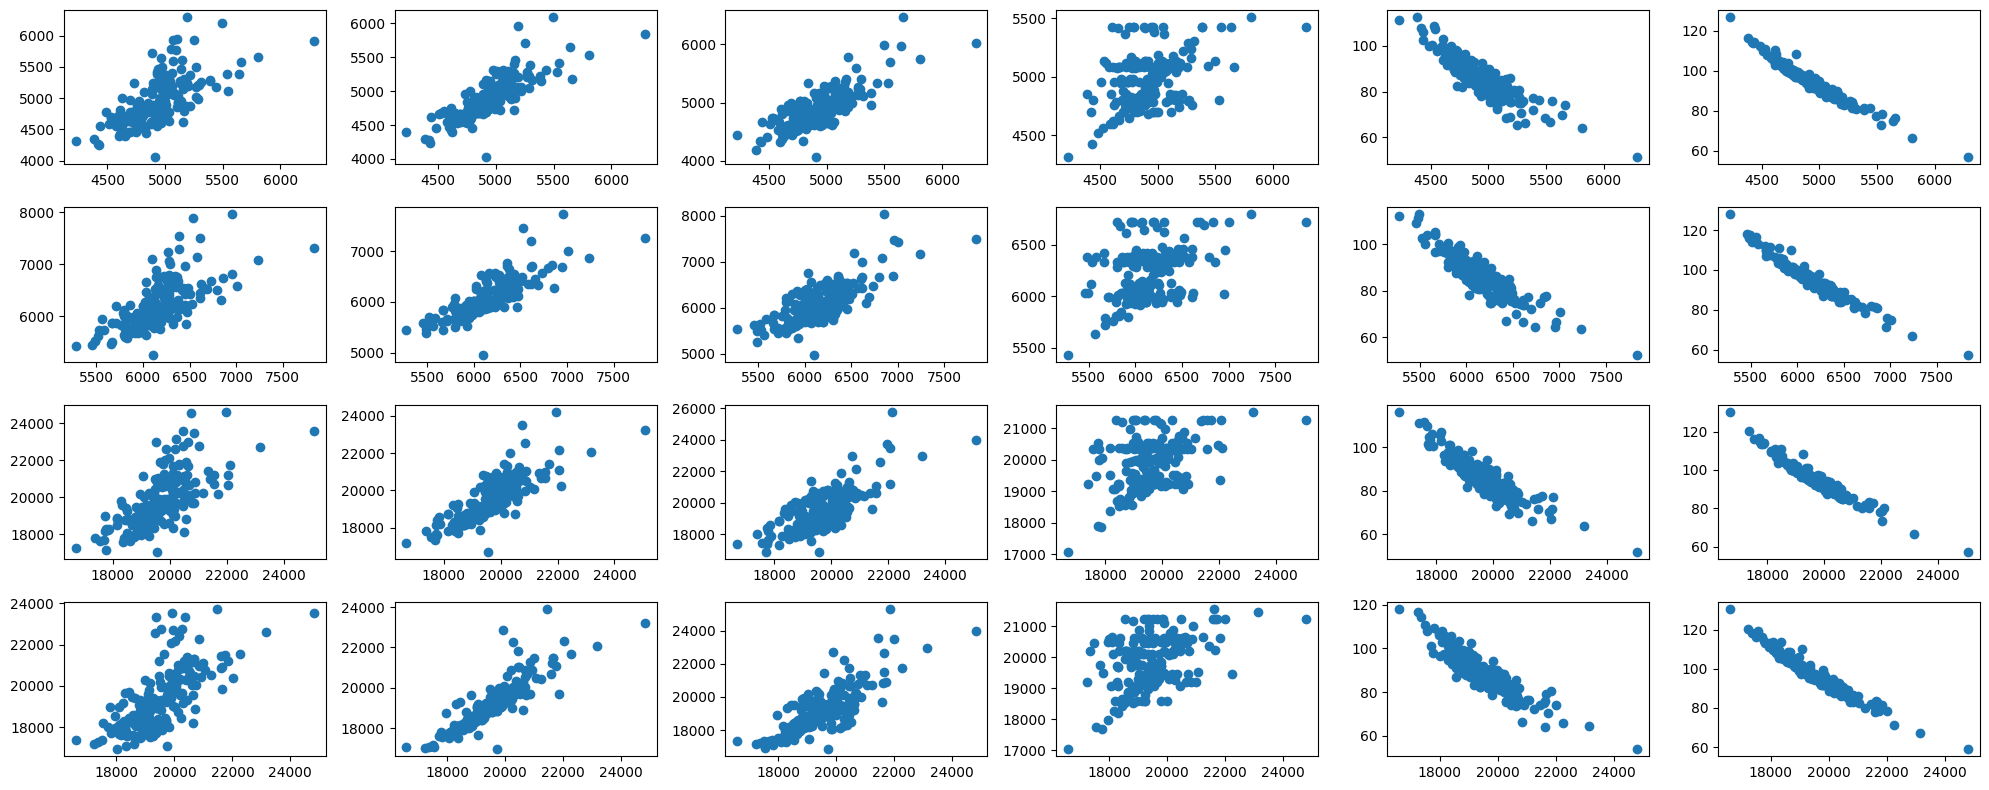

In [34]:
fig, ax = plt.subplots(4,6,figsize=(20,8))


stratum = 'wdam'
across = 0
down = 0
for m in methods_to_analyse:
    ax[across,down].scatter(performance[it][stratum][gt],performance[it][stratum][m])
    down += 1

stratum = 'wdpm'
across = 1
down = 0
for m in methods_to_analyse:
    ax[across,down].scatter(performance[it][stratum][gt],performance[it][stratum][m])
    down += 1

stratum = 'sat'
across = 2
down = 0
for m in methods_to_analyse:
    ax[across,down].scatter(performance[it][stratum][gt],performance[it][stratum][m])
    down += 1

stratum = 'bh'
across = 3
down = 0
for m in methods_to_analyse:
    ax[across,down].scatter(performance[it][stratum][gt],performance[it][stratum][m])
    down += 1

plt.tight_layout()
plt.show()

In [41]:
across,down

(0, 2)

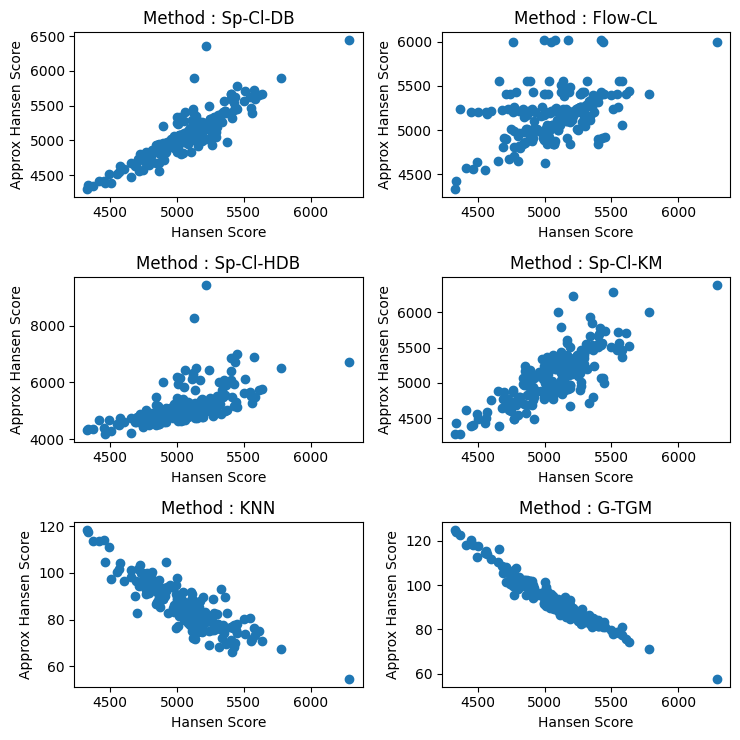

In [84]:
fig, ax = plt.subplots(3,2,figsize=(7.5,7.5))

stratum = 'wdam'

across = 0
down = 0
for m in methods_to_analyse:
    ax[down,across].scatter(performance[it][stratum][gt],performance[it][stratum][m])
    ax[down,across].set_xlabel('Hansen Score')
    ax[down,across].set_ylabel('Approx Hansen Score')
    ax[down,across].set_title('Method : {}'.format(methods_labels[m]))
    across += 1
    if across == 2:
        down += 1
        across = 0

plt.tight_layout()
plt.savefig(outputdir+'ch3_methods_vs_ground_truth.pdf')
plt.show()